<a href="https://colab.research.google.com/github/hirokimituya/stock-price-analysis/blob/main/technical_analysis/%E6%A0%AA%E4%BE%A1%E5%88%86%E6%9E%90%E9%96%A2%E6%95%B0_backtesting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install backtesting

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.5/175.5 kB 4.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for backtesting: filename=Backtesting-0.3.3-py3-none-any.whl size=173804 sha256=02ffbcf94d6b111292fe583b0389c3110c412d2fae62b7ca33a8a7a5c31aa53d
  Stored in directory: /root/.cache/pip/wheels/e2/30/7f/19cbe31987c6ebdb47f1f510343249066711609e3da2d57176
Successfully built backtesting


In [2]:
# Ta-Libの代替としてpandas_taを利用している。Ta-Libの関数名を小文字にしたものがあるイメージ
!pip install pandas_ta

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.1/115.1 kB 5.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pandas_ta: filename=pandas_ta-0.3.14b0-py3-none-any.whl size=218908 sha256=1ea712156bdded5ad97f365d1e3c2f6e315d2060b9026ce090ca182e4a0981f4
  Stored in directory: /root/.cache/pip/wheels/69/00/ac/f7fa862c34b0e2ef320175100c233377b4c558944f12474cf0
Successfully built pandas_ta


In [3]:
import pandas_datareader.data as pdr

# 株価データを取得するメソッド
def get_stock_data(code):
    """株価データを取得する

    :param code: 取得する株価データの銘柄コード
    :return: 株価データのデータフレーム
    """
    df = pdr.DataReader(f'{code}.JP', 'stooq').sort_index()
    return df

In [32]:
# バックテストの実行と結果の確認
from backtesting import Backtest
from backtesting import Strategy
from backtesting.lib import crossover
from backtesting.test import SMA
import datetime as dt

class SmaCross(Strategy):
    ns = 5   # 短期移動平均日数
    nl = 25   # 長期移動平均日数

    def init(self):
        # 短期移動平均
        self.smaS = self.I(SMA, self.data['Close'], self.ns)
        # 長期移動平均
        self.smaL = self.I(SMA, self.data['Close'], self.nl)
    
    def next(self):
        # smaS > smaL で買う
        if crossover(self.smaS, self.smaL):
            self.buy()
        # smaS < smaL で売る
        elif crossover(self.smaL, self.smaS):
            self.position.close()

def sma_cross_backtest(code, start, end=dt.date.today(), optimize=True, ns_periods=range(5, 75, 5), nl_periods=range(5, 75, 5), maximize='Return [%]'):
    """単純移動平均のゴールデンクロス／デッドクロスを用いた売買ルールのバックテストを実行する

    :param code: 取得する株価データの銘柄コード
    :param start: 取得する株価データの開始日
    :param end: 取得する株価データの終了日
    :param optimize: バックテストを最適化して実行するかどうか
    :param ns_periods: バックテストの最適化時に、短期移動平均線の値のリスト
    :param nl_periods: バックテストの最適化時に、長期移動平均線の値のリスト
    :param maximize: バックテストの最適化時に、どの値を最大にするように最適化するかの値（例: 'Return [%]' or 'SQN')
    """

    df = get_stock_data(code)
    data = df[start:end]

    bt = Backtest(data, SmaCross, trade_on_close=True)

    if optimize:
        # バックテストの最適化を実行
        result = bt.optimize(ns=ns_periods, nl=nl_periods, maximize=maximize, constraint=lambda p: p.ns < p.nl)
    else:
        # バックテスト実行
        result = bt.run()
    
    # 実行結果のデータを表示
    print(result)

    # 実行結果をグラフで表示
    bt.plot()

In [5]:
# RSIのゴールデンクロス／デッドクロスを用いた売買ルール
import pandas_ta as ta
import pandas as pd

def RSI(close, n1, n2):
    rsiS = ta.rsi(close, n1)
    rsiL = ta.rsi(close, n2)
    return rsiS, rsiL

class RSICross(Strategy):
    ns = 14 # 短期
    nl = 28 # 長期

    def init(self):
        self.rsiS, self.rsiL = self.I(RSI, pd.Series(self.data['Close']), self.ns, self.nl)
    
    def next(self):
        if crossover(self.rsiS, self.rsiL):
            self.buy()  # 短期 > 長期で買い
        elif crossover(self.rsiL, self.rsiS):
            self.position.close()   # 長期 > 短期で売り

def rsi_cross_backtest(code, start, end=dt.date.today(), optimize=True, ns_periods=range(5, 75, 5), nl_periods=range(5, 75, 5), maximize='Return [%]'):
    """RSIのゴールデンクロス／デッドクロスを用いた売買ルールのバックテストを実行する

    :param code: 取得する株価データの銘柄コード
    :param start: 取得する株価データの開始日
    :param end: 取得する株価データの終了日
    :param optimize: バックテストを最適化して実行するかどうか
    :param ns_periods: バックテストの最適化時に、短期移動平均線の値のリスト
    :param nl_periods: バックテストの最適化時に、長期移動平均線の値のリスト
    :param maximize: バックテストの最適化時に、どの値を最大にするように最適化するかの値（例: 'Return [%]' or 'SQN')
    """

    df = get_stock_data(code)
    data = df[start:end]

    bt = Backtest(data, RSICross, trade_on_close=True)

    if optimize:
        # バックテストの最適化を実行
        result = bt.optimize(ns=ns_periods, nl=nl_periods, maximize=maximize, constraint=lambda p: p.ns < p.nl)
    else:
        # バックテスト実行
        result = bt.run()
    
    # 実行結果のデータを表示
    print(result)

    # 実行結果をグラフで表示
    bt.plot()

In [34]:
# MACDのゴールデンクロス／デッドクロスを用いた売買ルール
import pandas_ta as ta
import pandas as pd

def MACD(close, n1, n2, n3):
    macd_df = ta.macd(close, fast=n1, slow=n2, signal=n3)
    macd, macdsignal = macd_df.iloc[:, 0], macd_df.iloc[:, 2]
    return macd, macdsignal

class MACDCross(Strategy):
    n1 = 12
    n2 = 26
    n3 = 9

    def init(self):
        self.macd, self.macdsignal = self.I(MACD, pd.Series(self.data['Close']), self.n1, self.n2, self.n3)
    
    def next(self):
        if crossover(self.macd, self.macdsignal):
            self.buy()  # macd > シグナルで買い
        elif crossover(self.macdsignal, self.macd):
            self.position.close()   # シグナル > macdで売り

def macd_cross_backtest(code, start, end=dt.date.today(), optimize=True, n1_periods=range(5, 75, 5), n2_periods=range(10, 75, 5), n3_periods=range(10, 75, 5), maximize='Return [%]'):
    """MACDのゴールデンクロス／デッドクロスを用いた売買ルールのバックテストを実行する

    :param code: 取得する株価データの銘柄コード
    :param start: 取得する株価データの開始日
    :param end: 取得する株価データの終了日
    :param optimize: バックテストを最適化して実行するかどうか
    :param n1_periods: バックテストの最適化時に、短期移動平均線の値のリスト
    :param n2_periods: バックテストの最適化時に、長期移動平均線の値のリスト
    :param n2_periods: バックテストの最適化時に、シグナル生成時の移動平均線の値のリスト
    :param maximize: バックテストの最適化時に、どの値を最大にするように最適化するかの値（例: 'Return [%]' or 'SQN')
    """

    df = get_stock_data(code)
    data = df[start:end]

    bt = Backtest(data, MACDCross, trade_on_close=True)

    if optimize:
        # バックテストの最適化を実行
        result = bt.optimize(n1=n1_periods, n2=n2_periods, n3=n3_periods, maximize=maximize, constraint=lambda p: p.n1 < p.n2)
    else:
        # バックテスト実行
        result = bt.run()
    
    # 実行結果のデータを表示
    print(result)

    # 実行結果をグラフで表示
    bt.plot()

In [33]:
sma_cross_backtest(2395, '2021-1-1', '2022-3-31')

Backtest.optimize:   0%|          | 0/3 [00:00<?, ?it/s]

Start                     2021-01-04 00:00:00
End                       2022-03-31 00:00:00
Duration                    451 days 00:00:00
Exposure Time [%]                   58.223684
Equity Final [$]                    25879.916
Equity Peak [$]                     25879.916
Return [%]                          158.79916
Buy & Hold Return [%]              156.444719
Return (Ann.) [%]                  119.950259
Volatility (Ann.) [%]               86.710332
Sharpe Ratio                         1.383344
Sortino Ratio                        5.372377
Calmar Ratio                         4.901885
Max. Drawdown [%]                  -24.470233
Avg. Drawdown [%]                   -6.338194
Max. Drawdown Duration      101 days 00:00:00
Avg. Drawdown Duration       22 days 00:00:00
# Trades                                    3
Win Rate [%]                            100.0
Best Trade [%]                      71.243358
Worst Trade [%]                     24.324183
Avg. Trade [%]                    

In [31]:
rsi_cross_backtest(2395, '2021-1-1', '2022-3-31')

Backtest.optimize:   0%|          | 0/3 [00:00<?, ?it/s]

Start                     2021-01-04 00:00:00
End                       2022-03-31 00:00:00
Duration                    451 days 00:00:00
Exposure Time [%]                   50.328947
Equity Final [$]                    30505.886
Equity Peak [$]                     30505.886
Return [%]                          205.05886
Buy & Hold Return [%]              156.444719
Return (Ann.) [%]                  152.074286
Volatility (Ann.) [%]              101.482111
Sharpe Ratio                         1.498533
Sortino Ratio                        9.030565
Calmar Ratio                         8.573569
Max. Drawdown [%]                  -17.737571
Avg. Drawdown [%]                   -3.909969
Max. Drawdown Duration       94 days 00:00:00
Avg. Drawdown Duration       21 days 00:00:00
# Trades                                   23
Win Rate [%]                        47.826087
Best Trade [%]                       73.87128
Worst Trade [%]                     -4.215358
Avg. Trade [%]                    

In [35]:
macd_cross_backtest(2395, '2021-1-1', '2022-3-31')

/usr/local/lib/python3.10/dist-packages/backtesting/backtesting.py:1488: UserWarning: Searching for best of 1183 configurations.
  output = _optimize_grid()


Backtest.optimize:   0%|          | 0/4 [00:00<?, ?it/s]

Start                     2021-01-04 00:00:00
End                       2022-03-31 00:00:00
Duration                    451 days 00:00:00
Exposure Time [%]                   47.697368
Equity Final [$]                    29876.953
Equity Peak [$]                     30210.503
Return [%]                          198.76953
Buy & Hold Return [%]              156.444719
Return (Ann.) [%]                  147.758623
Volatility (Ann.) [%]              100.074438
Sharpe Ratio                         1.476487
Sortino Ratio                        8.568002
Calmar Ratio                         9.154101
Max. Drawdown [%]                  -16.141249
Avg. Drawdown [%]                    -4.20448
Max. Drawdown Duration       85 days 00:00:00
Avg. Drawdown Duration       21 days 00:00:00
# Trades                                   10
Win Rate [%]                             70.0
Best Trade [%]                      77.419673
Worst Trade [%]                    -10.353574
Avg. Trade [%]                    

# yahoo_finance_api2を使った株価データ取得（分足データを取得することもできる）



In [11]:
!pip install yahoo_finance_api2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for yahoo_finance_api2: filename=yahoo_finance_api2-0.0.12-py3-none-any.whl size=3714 sha256=fba7db66837b4bd0ded6a4850dc29fcb8fcfbcb6654155e84792969b2c38205a
  Stored in directory: /root/.cache/pip/wheels/e2/40/e3/f3d8054a41d7d85065555037525f48f56119cafbc5fcddf427
Successfully built yahoo_finance_api2


In [12]:
from yahoo_finance_api2 import share as yapi2
import datetime as dt
from datetime import date,timedelta
import pandas as pd

# 株価データを取得するメソッド
def get_stock_data_yapi2(code):
    """株価データを取得する

    :param code: 取得する株価データの銘柄コード
    :return: 株価データのデータフレーム
    """
    data = yapi2.Share(f'{code}.T').get_historical(
        yapi2.PERIOD_TYPE_YEAR,
        10,
        yapi2.FREQUENCY_TYPE_DAY,
        1
    )

    df = pd.DataFrame(data)

    # タイムスタンプをDateTime型に変更
    df['datetime'] = pd.to_datetime(df['timestamp'], unit='ms')

    # 日本時間へ変換
    df['Date'] = df['datetime'] + dt.timedelta(hours=9)

    # インデックスをDateカラムに設定
    df.index = df['Date'].dt.date

    # 不要なカラムを削除
    del df['Date'], df['datetime'], df['timestamp']

    # 各カラムの最初の文字を大文字に変換
    for col in df.columns:
        df[f'{col.capitalize()}'] = df[col]
        del df[col]

    return df

df = get_stock_data_yapi2(4751)
df

,Open,High,Low,Close,Volume
Date,,,,,
2013-05-28,247.500,256.250,244.125,250.500,9413600
2013-05-29,250.000,251.375,246.125,246.875,9849600
2013-05-30,243.750,255.000,242.625,247.625,11440800
2013-05-31,250.750,252.500,247.000,247.750,7107200
2013-06-03,245.125,253.125,244.750,249.875,8889600
...,...,...,...,...,...
2023-05-19,1152.000,1152.000,1100.000,1104.000,5523000
2023-05-22,1106.000,1108.000,1081.000,1105.000,4048300
2023-05-23,1110.000,1111.000,1079.000,1084.000,3966100


# PythonのBacktesting.pyの使い方を解説！日本株でバックテストをしてみる

参考URL: https://myfrankblog.com/backtest_with_python/

売買戦略詳細
* 移動平均線は10日、20日、100日を使う
* 100日移動平均線の傾きでトレンドを把握して、上向きで上昇トレンド、下向きなら下落トレンドと判定する
* 10日、20日移動平均線が100日移動平均線を上回っている状態でゴールデンクロスが発生したらエントリー
* エントリーは直近ローソク足の高値で指値、直近終値の8％下落で損切り、15％で利食いで注文
* 10日、20日移動平均線でデッドクロスが発生したらポジションを強制的にクローズ

In [13]:
from backtesting import Backtest, Strategy
import pandas as pd
import numpy as np

def moving_average(x, n):
    return pd.Series(x).rolling(window=n).mean()

def find_cross(short, long):
    diff = np.where(pd.Series(short) - pd.Series(long) > 0, 1, 0)
    return pd.Series(diff).diff()

def trend(x):
    return np.where(pd.Series(x).diff() > 0, 1, 0)

class SmaCross(Strategy):
    n1 = 10
    n2 = 20
    n3 = 100
    sl = 0.92
    tp = 1.15

    def init(self):
        close = self.data.Close
        self.sma1 = self.I(moving_average, close, self.n1)
        self.sma2 = self.I(moving_average, close, self.n2)
        self.sma3 = self.I(moving_average, close, self.n3)
        self.cross = self.I(find_cross, self.sma1, self.sma2)
        self.trend = self.I(trend, self.sma3)

    def next(self):
        price = self.data.Close[-1]
        limit = self.data.High[-1]

        if self.cross == 1 and self.trend == 1 and self.sma1 > self.sma3 and self.sma2 > self.sma3:
            self.buy(limit=limit, sl=price*self.sl, tp=price*self.tp, size=100)
        elif self.cross == -1:
            self.position.close()


bt = Backtest(df, SmaCross,
              cash=1000000, commission=.002,
              exclusive_orders=True)

output = bt.run()
bt.plot()

<ipython-input-13-d82fddadf2d1>:40: UserWarning: Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.
  bt = Backtest(df, SmaCross,


Row(id='3141', ...)

In [14]:
print(output)

Start                              2013-05-28
End                                2023-05-25
Duration                   3649 days 00:00:00
Exposure Time [%]                    11.12013
Equity Final [$]                    1055217.0
Equity Peak [$]                     1082695.5
Return [%]                             5.5217
Buy & Hold Return [%]              300.798403
Return (Ann.) [%]                         0.0
Volatility (Ann.) [%]                     NaN
Sharpe Ratio                              NaN
Sortino Ratio                             NaN
Calmar Ratio                              0.0
Max. Drawdown [%]                   -3.214893
Avg. Drawdown [%]                   -0.824926
Max. Drawdown Duration      850 days 00:00:00
Avg. Drawdown Duration      191 days 00:00:00
# Trades                                   23
Win Rate [%]                        43.478261
Best Trade [%]                      16.855594
Worst Trade [%]                     -9.436446
Avg. Trade [%]                    

In [24]:
# 最適化されたパラメータを表示
print(output._strategy.n1, output._strategy.n2)

10 20


In [23]:
output = bt.optimize(n3=range(50, 200, 10))
bt.plot()

Backtest.optimize:   0%|          | 0/3 [00:00<?, ?it/s]

Row(id='5077', ...)

In [22]:
print(output)

Start                              2013-05-28
End                                2023-05-25
Duration                   3649 days 00:00:00
Exposure Time [%]                    11.12013
Equity Final [$]                    1055217.0
Equity Peak [$]                     1082695.5
Return [%]                             5.5217
Buy & Hold Return [%]              300.798403
Return (Ann.) [%]                         0.0
Volatility (Ann.) [%]                     NaN
Sharpe Ratio                              NaN
Sortino Ratio                             NaN
Calmar Ratio                              0.0
Max. Drawdown [%]                   -3.214893
Avg. Drawdown [%]                   -0.824926
Max. Drawdown Duration      850 days 00:00:00
Avg. Drawdown Duration      191 days 00:00:00
# Trades                                   23
Win Rate [%]                        43.478261
Best Trade [%]                      16.855594
Worst Trade [%]                     -9.436446
Avg. Trade [%]                    

In [21]:
# 資産推移データを表示
output._equity_curve.head()

,Equity,DrawdownPct,DrawdownDuration
2013-05-28,1000000.0,0.0,NaT
2013-05-29,1000000.0,0.0,NaT
2013-05-30,1000000.0,0.0,NaT
2013-05-31,1000000.0,0.0,NaT
2013-06-03,1000000.0,0.0,NaT


<Axes: >

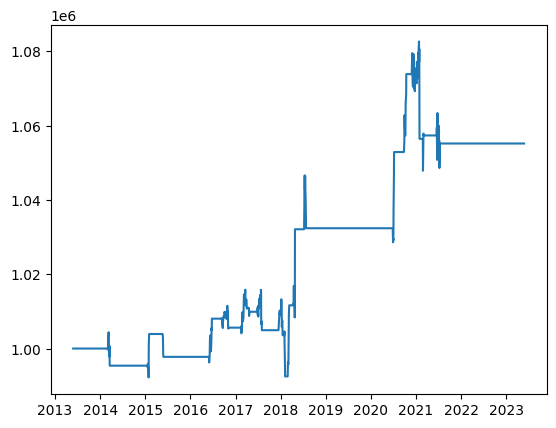

In [20]:
# 資産推移をグラフ表示
output._equity_curve["Equity"].plot()